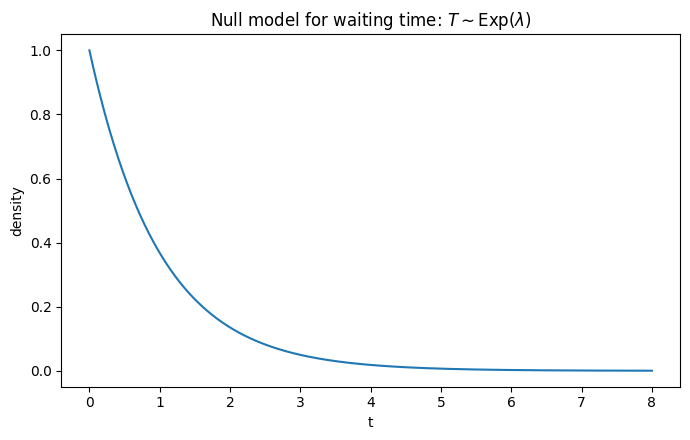

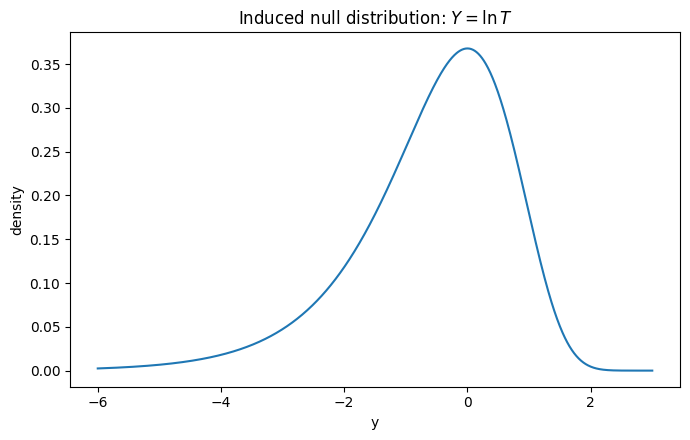

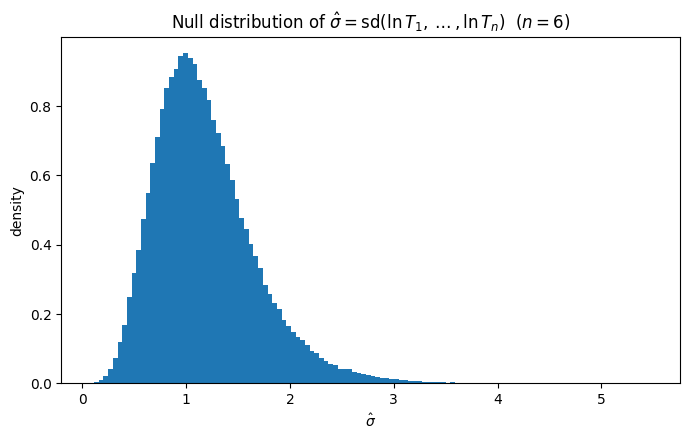

{'n': 6, 'lambda': 1.0, '2.5%': 0.4512618408611295, 'median': 1.1126070121884877, '97.5%': 2.354623521425169}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Null model + helper functions
# -----------------------------

def exp_pdf(t: np.ndarray, lam: float) -> np.ndarray:
    """PDF of Exp(rate=lam) on t>=0."""
    t = np.asarray(t)
    out = lam * np.exp(-lam * t)
    out[t < 0] = 0.0
    return out

def log_exp_pdf(y: np.ndarray, lam: float) -> np.ndarray:
    """
    If T ~ Exp(lam) and Y = ln T, then
        f_Y(y) = lam * exp(y) * exp(-lam * exp(y)),  y in (-inf, inf).
    """
    y = np.asarray(y)
    ey = np.exp(y)
    return lam * ey * np.exp(-lam * ey)

def simulate_sigma_log_times(n: int, lam: float = 1.0, sims: int = 200_000, seed: int = 0) -> np.ndarray:
    """
    Monte Carlo null distribution for the Schmidt-style statistic:
        sigma_hat = sd(ln T_1,...,ln T_n) with denominator (n-1).

    H0: T_i iid ~ Exp(rate=lam).
    """
    rng = np.random.default_rng(seed)
    t = rng.exponential(scale=1.0 / lam, size=(sims, n))  # T_i ~ Exp(lam)
    y = np.log(t)                                         # log-times
    return y.std(axis=1, ddof=1)                           # ddof=1 => n-1 denominator

def p_value_from_null_samples(sigma_obs: float, sigma_null: np.ndarray, tail: str = "right") -> float:
    """
    Estimate p-value using Monte Carlo samples of the null distribution.

    tail:
      - "right": p = P(sigma >= sigma_obs)
      - "left":  p = P(sigma <= sigma_obs)
      - "two":   p = 2*min(P(sigma>=sigma_obs), P(sigma<=sigma_obs))
    """
    if tail == "right":
        return float(np.mean(sigma_null >= sigma_obs))
    if tail == "left":
        return float(np.mean(sigma_null <= sigma_obs))
    if tail == "two":
        pr = np.mean(sigma_null >= sigma_obs)
        pl = np.mean(sigma_null <= sigma_obs)
        return float(2.0 * min(pr, pl))
    raise ValueError("tail must be one of {'right','left','two'}")

# -----------------------------
# User-controlled parameters
# -----------------------------

lam = 1.0        # rate under H0 (scale doesn't matter much for log-spread)
n = 6            # number of times in your set (edit this)
sims = 200_000   # Monte Carlo draws
seed = 1

# If you have an observed sigma (from your real t_i), put it here; else None
sigma_obs = None  # e.g. 1.37

# -----------------------------
# Plots: T, ln T, and sigma_hat
# -----------------------------

# 1) Exp waiting time under H0
tgrid = np.linspace(0, 8, 900)
plt.figure(figsize=(7, 4.5))
plt.plot(tgrid, exp_pdf(tgrid, lam))
plt.title(r"Null model for waiting time: $T \sim \mathrm{Exp}(\lambda)$")
plt.xlabel("t")
plt.ylabel("density")
plt.tight_layout()
plt.show()

# 2) Log-time density under H0
ygrid = np.linspace(-6, 3, 1200)
plt.figure(figsize=(7, 4.5))
plt.plot(ygrid, log_exp_pdf(ygrid, lam))
plt.title(r"Induced null distribution: $Y=\ln T$")
plt.xlabel("y")
plt.ylabel("density")
plt.tight_layout()
plt.show()

# 3) Monte Carlo null distribution for sigma_hat
sigma_null = simulate_sigma_log_times(n=n, lam=lam, sims=sims, seed=seed)

plt.figure(figsize=(7, 4.5))
plt.hist(sigma_null, bins=120, density=True)
plt.title(rf"Null distribution of $\hat\sigma=\mathrm{{sd}}(\ln T_1,\dots,\ln T_n)$  ($n={n}$)")
plt.xlabel(r"$\hat\sigma$")
plt.ylabel("density")

# Optional: overlay observed value + p-values
if sigma_obs is not None:
    plt.axvline(sigma_obs, linewidth=2)
    print({
        "sigma_obs": sigma_obs,
        "p_right": p_value_from_null_samples(sigma_obs, sigma_null, "right"),
        "p_two_sided": p_value_from_null_samples(sigma_obs, sigma_null, "two"),
    })

plt.tight_layout()
plt.show()

# Reference quantiles (quick congruence interval)
q025, q50, q975 = np.quantile(sigma_null, [0.025, 0.50, 0.975])
print({"n": n, "lambda": lam, "2.5%": float(q025), "median": float(q50), "97.5%": float(q975)})


Toy look-elsewhere test under a Poisson/exponential null
Rate λ = 0.2 events/sec, total time T = 2000.0 sec (mean events ≈ 400.0)
Chain length k = 4, observed threshold τ_obs = 0.2 sec
Monte Carlo p-value: P(D_min ≤ τ_obs | H0) ≈ 0.004050
Estimated n_b (expected # accidental chains in full search) ≈ 0.004050
Poisson approx P(≥1 accidental chain) ≈ 1-exp(-n_b) = 0.004042


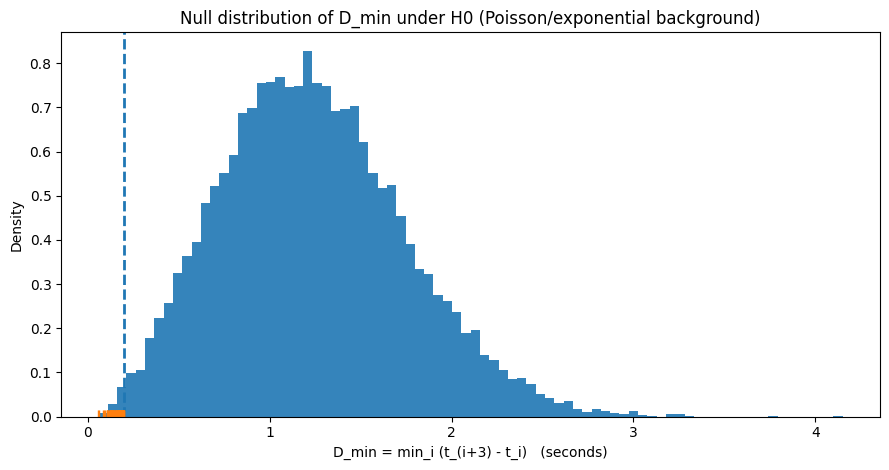

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Look-elsewhere Monte Carlo using an exponential/Poisson null
# ------------------------------------------------------------
# H0: background events follow a Poisson process with rate lambda_rate
#     => inter-arrival times are Exp(lambda_rate).
#
# Efficient simulation trick:
#   If N ~ Poisson(lambda_rate * T_total) and conditional on N,
#   event times are the sorted order statistics of Uniform(0, T_total).
#
# "Chain" definition (toy but captures look-elsewhere):
#   k consecutive events occur within tau seconds:
#       t_{i+k-1} - t_i <= tau
#
# Look-elsewhere statistic:
#   D_min = min_i (t_{i+k-1} - t_i) over the whole dataset
# Extreme = "very small D_min"
# p-value = P(D_min <= tau_obs | H0)

lambda_rate = 0.2   # events per second
T_total = 2_000.0   # seconds of data-taking (mean events ~ 400)
k = 4               # chain length
tau_obs = 0.20      # "observed extreme": 4 events within 0.10 sec

Nmc = 20_000
rng = np.random.default_rng(0)

def dmin_and_count(times, k, tau):
    if times.size < k:
        return np.inf, 0
    spans = times[k-1:] - times[:-(k-1)]
    return float(np.min(spans)), int(np.sum(spans <= tau))

D_min = np.empty(Nmc, dtype=float)
chain_counts = np.empty(Nmc, dtype=int)

mean_N = lambda_rate * T_total
for i in range(Nmc):
    N = rng.poisson(mean_N)
    if N < k:
        D_min[i] = np.inf
        chain_counts[i] = 0
        continue
    times = np.sort(rng.uniform(0.0, T_total, size=N))
    D_min[i], chain_counts[i] = dmin_and_count(times, k, tau_obs)

# Global Monte Carlo p-value (look-elsewhere already included)
p_hat = np.mean(D_min <= tau_obs)

# Also estimate the "globalized" mean number of accidental chains n_b
n_b_hat = float(np.mean(chain_counts))
p_at_least_one_via_poisson = 1.0 - np.exp(-n_b_hat)

print("Toy look-elsewhere test under a Poisson/exponential null")
print(f"Rate λ = {lambda_rate} events/sec, total time T = {T_total} sec (mean events ≈ {mean_N:.1f})")
print(f"Chain length k = {k}, observed threshold τ_obs = {tau_obs} sec")
print(f"Monte Carlo p-value: P(D_min ≤ τ_obs | H0) ≈ {p_hat:.6f}")
print(f"Estimated n_b (expected # accidental chains in full search) ≈ {n_b_hat:.6f}")
print(f"Poisson approx P(≥1 accidental chain) ≈ 1-exp(-n_b) = {p_at_least_one_via_poisson:.6f}")

# Plot distribution of D_min and mark the "more extreme" region (left of τ_obs)
finite = np.isfinite(D_min)
D_plot = D_min[finite]

fig, ax = plt.subplots(figsize=(9, 4.8))
ax.hist(D_plot, bins=80, density=True, alpha=0.9)

ax.axvline(tau_obs, linestyle="--", linewidth=2)

# "More extreme" simulations: D_min <= tau_obs (left tail)
extreme = D_plot[D_plot <= tau_obs]
ax.plot(extreme, np.zeros_like(extreme), "|", markersize=10)

ax.set_title("Null distribution of D_min under H0 (Poisson/exponential background)")
ax.set_xlabel(f"D_min = min_i (t_(i+{k-1}) - t_i)   (seconds)")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()
